The purpose of this notebook is to evaluate GPDs $G_q(x,\eta,t)$ as well as their conformal moments $\mathbb{G}_q(n,\eta,t)$, where, for a generic GPD, we have its conformal moment expansion
\begin{equation}
G_q(x,\eta,t)=\sum_{n=0}^\infty (-1)^{n}p_n(x,\eta)\mathbb{F}_q(n,\eta,t),\qquad G_g(x,\eta,t)=\sum_{n=1}^\infty (-1)^{n-1}\, {^g\!p}_n(x,\eta) \mathbb{G}_g(n,\eta,t),
\end{equation}
where $G=H,E,\widetilde{H},\widetilde{E},H^T,E^T,\widetilde{H}^T,\widetilde{E}^T$.

To this end, we import the MSTW PDF parametrization of PDFs. The conformal moments are obtained by Reggeized $x$ integrals over PDFs at some input scale $\mu_0=1$ GeV and evolved using the pertinent RGEs.

In [1]:
# Import necessary libraries and set display options
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from matplotlib.ticker import LogLocator, FuncFormatter
from scipy.special import digamma
import re
import os

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Set width to avoid wrapping
pd.set_option('display.max_colwidth', None) # Show full content of each column

np.set_printoptions(linewidth=200)

File handling, read in data, define dictionary for publication and color coding. Automatically parse all publications.

In [ ]:
# MSTW PDF data
# Base path to main data directory
base_path = "/mnt/c/Users/flori/Documents/PostDoc/Jupyter/Data/GPD/"
# Define the file path to the .dat file and extract its content
MSTW_path = f"{base_path}MSTW_Table_4.dat"
# Read the .dat file into a DataFrame
columns = ["Parameter", "LO", "NLO", "NNLO"]
data = []

# Parsing the .dat file
with open(MSTW_path, "r") as file:
    for line in file:
        # Skip header lines
        if line.startswith("#") or line.strip() == "":
            continue
        
        # Split the line into columns
        parts = line.split("\t")
        parameter = parts[0]
        lo_values = eval(parts[1].strip())  # Convert string "[...]" to a Python list
        nlo_values = eval(parts[2].strip())
        nnlo_values = eval(parts[3].strip())
        
        # Append to the data list
        data.append([parameter, lo_values, nlo_values, nnlo_values])

# Create a DataFrame from the parsed data
MSTWpdf = pd.DataFrame(data, columns=columns)

In [ ]:
#Lattice data
# Add some colors
saturated_pink = (1.0, 0.1, 0.6)  # Higher red, some blue, minimal green

# Define a dictionary that maps publication IDs to a color
publication_mapping = {
        "2305.11117": "cyan",
        "0705.4295": "orange",
        "1908.10706": saturated_pink
    # Add more publication IDs and corresponding colors here
}

def load_lattice_data(moment_type, moment_label, pub_id):
    """
    Load data from a .dat file, extracting 'n' values from the header and associating them with rows.

    Args:
        moment_type (str): The type of moment (e.g., "Isovector").
        moment_label (str): The label of the moment (e.g., "A").
        pub_id (str): The publication ID.

    Returns:
        tuple: A tuple containing the data, and a dictionary mapping 'n' values to row indices.
    """

    filename = f"{moment_type}Moments{moment_label}{pub_id}.dat"
    file_path = f"{base_path}{filename}"

    # Check if the file exists
    if not os.path.exists(file_path):
        #print(f"File {filename} not found. Skipping.")
        return None

    with open(file_path, 'r') as f:
        header = f.readline().strip()
        data = np.loadtxt(f)

    with open(file_path, 'r') as f:
        header = f.readline().strip()
        data = np.loadtxt(f)

    # Extract 'n' values from the header
    n_values = []
    for col_name in header.split():
        match = re.search(rf'{moment_label}(\d+)0_', col_name)
        if match:
            n_values.append(int(match.group(1)))

    # Create a dictionary mapping 'n' values to row indices
    n_to_row_map = {n: i for i, n in enumerate(n_values)}

    return data, n_to_row_map

# Accessor functions for -t, values, and errors
def t_values(moment_type, moment_label, pub_id):
    """Return the -t values for a given moment type, label, and publication ID."""
    result = load_lattice_data(moment_type, moment_label, pub_id)

    if result is None:
        print(f"No data found for {moment_type} {moment_label} {pub_id}. Skipping.")
        return None
    
    data, _ = result
    
    return data[:, 0]

def Fn0_values(n, moment_type, moment_label, pub_id):
    """
    Return central values for An0 for a given n, moment type, label, and publication ID.
    """
    result = load_lattice_data(moment_type, moment_label, pub_id)

    if result is None:
        print(f"No data found for {moment_type} {moment_label} {pub_id}. Skipping.")
        return None
    
    data, n_to_row_map = result
    
    # Check if the requested n is available in the data
    if n not in n_to_row_map:
        return None  # Requested n does not exist
    
    # Get the corresponding column index for An0_val
    col_idx = n_to_row_map[n]
    
    # Return the column data
    return data[:, col_idx]

def Fn0_errors(n, moment_type, moment_label, pub_id):
    """
    Return errors for An0 for a given n, moment type, label, and publication ID.
    """
    result = load_lattice_data(moment_type, moment_label, pub_id)

    if result is None:
        print(f"No data found for {moment_type} {moment_label} {pub_id}. Skipping.")
        return None
    
    data, n_to_row_map = result
    
    # Check if the requested n is available in the data
    if n not in n_to_row_map:
        return None  # Requested n does not exist
    
    # Get the corresponding column index for An0_err
    col_idx = n_to_row_map[n]+1
    
    # Return the column data
    return data[:, col_idx]

In [ ]:
# Check if data files are parsed correctly
for ID in publication_mapping:
    moment_type = "NonSingletIsovector"
    #moment_type = "NonSingletIsoscalar"
    moment_label = "B"
    
    print(f"Publication ID: {ID}")
    
    # Get the t_values and check if it's valid
    t_vals = t_values(moment_type, moment_label, ID)
    print("t_values:", t_vals)
    
    # Iterate through n from 1 to 5
    for n in range(1, 6):
        print(f"Checking n = {n}")
        
        # Get the F{n}0 moment_type values and check if it's valid
        Fn0_vals = Fn0_values(n, moment_type, moment_label, ID)
        if Fn0_vals is not None:
            print(f"{moment_label}{n}0 {moment_type} values:", Fn0_vals)
        else:
            print(f"{moment_label}{n}0 {moment_type} values: No data available.")
        
        # Get the F{n}0 moment_type errors and check if it's valid
        Fn0_errs = Fn0_errors(n, moment_type, moment_label, ID)
        if Fn0_errs is not None:
            print(f"{moment_label}{n}0 {moment_type} errors:", Fn0_errs)
        else:
            print(f"{moment_label}{n}0 {moment_type} errors: No data available.")    

Publication ID: 2305.11117
t_values: [0.17 0.34 0.65 0.69 0.81 1.24 1.38 1.38 1.52 2.29 2.77]
Checking n = 1
B10 NonSingletIsovector values: [1.964 1.547 1.107 1.073 0.895 0.609 0.561 0.52  0.443 0.306 0.199]
B10 NonSingletIsovector errors: [0.1424 0.1132 0.0494 0.0375 0.0611 0.0522 0.0421 0.0331 0.0654 0.0812 0.0191]
Checking n = 2
B20 NonSingletIsovector values: [0.247 0.256 0.192 0.215 0.164 0.124 0.114 0.114 0.083 0.085 0.067]
B20 NonSingletIsovector errors: [0.0332 0.0321 0.0182 0.013  0.0231 0.0201 0.0181 0.0131 0.0191 0.0322 0.0091]
Checking n = 3
B30 NonSingletIsovector values: [0.114 0.065 0.079 0.061 0.046 0.04  0.058 0.031 0.017 0.036 0.018]
B30 NonSingletIsovector errors: [0.0204 0.0143 0.0108 0.0085 0.0098 0.0121 0.0095 0.0054 0.013  0.0158 0.0045]
Checking n = 4
B40 NonSingletIsovector values: [0.034 0.041 0.031 0.021 0.019 0.013 0.021 0.016 0.001 0.031 0.011]
B40 NonSingletIsovector errors: [0.0121 0.0092 0.0064 0.0098 0.0073 0.0067 0.0067 0.0045 0.0095 0.0166 0.0032]
Ch

In [4]:
# Display the DataFrame
print("Parsed DataFrame:")
display(MSTWpdf)

Parsed DataFrame:


,Parameter,LO,NLO,NNLO
0,alpha_S(Q0^2),"[0.68183, 0, 0]","[0.49128, 0, 0]","[0.45077, 0, 0]"
1,alpha_S(M_Z^2),"[0.13939, 0, 0]","[0.12018, 0, 0]","[0.11707, 0, 0]"
2,A_u,"[1.4335, 0, 0]","[0.25871, 0, 0]","[0.2225, 0, 0]"
3,eta_1,"[0.45232, 0.022, -0.018]","[0.29065, 0.019, -0.013]","[0.27871, 0.018, -0.014]"
4,eta_2,"[3.0409, 0.079, -0.067]","[3.2432, 0.062, -0.039]","[3.3627, 0.061, -0.044]"
5,epsilon_u,"[-2.3737, 0.54, -0.48]","[4.0603, 1.6, -2.3]","[4.4343, 2.4, -2.7]"
6,gamma_u,"[8.9924, 0, 0]","[30.687, 0, 0]","[38.599, 0, 0]"
7,A_d,"[5.0903, 0, 0]","[12.288, 0, 0]","[17.938, 0, 0]"
8,eta_3,"[0.71978, 0.057, -0.082]","[0.96809, 0.11, -0.11]","[1.0839, 0.12, -0.11]"
9,eta_4-eta_2,"[2.0835, 0.32, -0.45]","[2.7003, 0.5, -0.52]","[2.7865, 0.5, -0.44]"


In [5]:
# Extract LO, NLO and NLO columns
MSTWpdf_LO=MSTWpdf[["LO"]]
MSTWpdf_NLO=MSTWpdf[["NLO"]]
MSTWpdf_NNLO=MSTWpdf[["NNLO"]]

In [8]:
# Define the PDFs using Eqs. (6-12) in  0901.0002 
def uv(x, error_type="central"):
    """
    Compute the uv(x) PDF based on the given LO parameters and selected errors.
    
    Arguments:
    x -- The value of parton x.
    error_type -- A string indicating whether to use 'central', 'plus', or 'minus' errors. Default is 'central'.
    
    Returns:
    The value of uv(x) based on the selected parameters and error type.
    """
     # Define a dictionary that maps the error_type to column indices
    error_mapping = {
        "central": 0,  # The column with the central value
        "plus": 1,     # The column with the + error value
        "minus": 2     # The column with the - error value
    }
    
    # Get the column index corresponding to the error_type
    error_col_index = error_mapping.get(error_type, 0)  # Default to 'central' if error_type is invalid

    # Get row index of entry
    index_A_u=MSTWpdf[MSTWpdf["Parameter"] == "A_u"].index[0]
    index_eta_1=MSTWpdf[MSTWpdf["Parameter"] == "eta_1"].index[0]
    index_eta_2=MSTWpdf[MSTWpdf["Parameter"] == "eta_2"].index[0]
    index_epsilon_u=MSTWpdf[MSTWpdf["Parameter"] == "epsilon_u"].index[0]
    index_gamma_u=MSTWpdf[MSTWpdf["Parameter"] == "gamma_u"].index[0]

    # Extracting parameter values based on the error_type argument
    A_u = MSTWpdf_LO.iloc[index_A_u,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_A_u,0][error_col_index]
    eta_1 = MSTWpdf_LO.iloc[index_eta_1,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_eta_1,0][error_col_index]
    eta_2 = MSTWpdf_LO.iloc[index_eta_2,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_eta_2,0][error_col_index]
    epsilon_u = MSTWpdf_LO.iloc[index_epsilon_u,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_epsilon_u,0][error_col_index]
    gamma_u = MSTWpdf_LO.iloc[index_gamma_u,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_gamma_u,0][error_col_index]
    
    # Compute the uv(x) equation using numpy operations
    result = A_u * (x ** (eta_1 - 1)) * ((1 - x) ** eta_2) * (1 + epsilon_u * np.sqrt(x) + gamma_u * x)
    
    return result

def dv(x, error_type="central"):
    # Define a dictionary that maps the error_type to column indices
    error_mapping = {
        "central": 0,  # The column with the central value
        "plus": 1,     # The column with the + error value
        "minus": 2     # The column with the - error value
    }
    
    # Get the column index corresponding to the error_type
    error_col_index = error_mapping.get(error_type, 0)

    # Get row index of entry
    index_A_d = MSTWpdf[MSTWpdf["Parameter"] == "A_d"].index[0]
    index_eta_3 = MSTWpdf[MSTWpdf["Parameter"] == "eta_3"].index[0]
    index_eta_2=MSTWpdf[MSTWpdf["Parameter"] == "eta_2"].index[0]
    # Only eta_4-eta_2 given
    index_eta_42 = MSTWpdf[MSTWpdf["Parameter"] == "eta_4-eta_2"].index[0]
    index_epsilon_d = MSTWpdf[MSTWpdf["Parameter"] == "epsilon_d"].index[0]
    index_gamma_d = MSTWpdf[MSTWpdf["Parameter"] == "gamma_d"].index[0]

    # Extracting parameter values based on the error_type argument
    A_d = MSTWpdf_LO.iloc[index_A_d, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_A_d, 0][error_col_index]
    eta_3 = MSTWpdf_LO.iloc[index_eta_3, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_eta_3, 0][error_col_index]
    # eta_4=(eta_4-eta_2) + eta_2, Add errors in quadrature
    eta_4 = (MSTWpdf_LO.iloc[index_eta_42, 0][0] + MSTWpdf_LO.iloc[index_eta_2, 0][0]) + int(error_col_index>0) *np.sign(MSTWpdf_LO.iloc[index_eta_42, 0][error_col_index]) * np.sqrt(MSTWpdf_LO.iloc[index_eta_42, 0][error_col_index]**2+MSTWpdf_LO.iloc[index_eta_2, 0][error_col_index]**2)
    epsilon_d = MSTWpdf_LO.iloc[index_epsilon_d, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_epsilon_d, 0][error_col_index]
    gamma_d = MSTWpdf_LO.iloc[index_gamma_d, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_gamma_d, 0][error_col_index]
    
    # Compute the uv(x) equation using numpy operations
    result = A_d * (x ** (eta_3 - 1)) * ((1 - x) ** eta_4) * (1 + epsilon_d * np.sqrt(x) + gamma_d * x)
    
    return result

def sv(x, error_type="central"):
    error_mapping = {
        "central": 0,
        "plus": 1,
        "minus": 2
    }
    
    error_col_index = error_mapping.get(error_type, 0)

    # delta_- fixed to 0.2
    index_A_m = MSTWpdf[MSTWpdf["Parameter"] == "A_-"].index[0]
    index_eta_m = MSTWpdf[MSTWpdf["Parameter"] == "eta_-"].index[0]
    index_x_0 = MSTWpdf[MSTWpdf["Parameter"] == "x_0"].index[0]

    A_m = MSTWpdf_LO.iloc[index_A_m, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_A_m, 0][error_col_index]
    delta_m = .2
    eta_m = MSTWpdf_LO.iloc[index_eta_m, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_eta_m, 0][error_col_index]
    x_0 = MSTWpdf_LO.iloc[index_x_0, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_x_0, 0][error_col_index]

    result = A_m * (x ** (delta_m - 1)) * ((1 - x) ** eta_m) * (1 -x/x_0)
    
    return result

def Sv(x, error_type="central"):
    error_mapping = {
        "central": 0,
        "plus": 1,
        "minus": 2
    }
    
    error_col_index = error_mapping.get(error_type, 0)

    index_A_S = MSTWpdf[MSTWpdf["Parameter"] == "A_S"].index[0]
    index_delta_S = MSTWpdf[MSTWpdf["Parameter"] == "delta_S"].index[0]
    index_eta_S = MSTWpdf[MSTWpdf["Parameter"] == "eta_S"].index[0]
    index_epsilon_S = MSTWpdf[MSTWpdf["Parameter"] == "epsilon_S"].index[0]
    index_gamma_S = MSTWpdf[MSTWpdf["Parameter"] == "gamma_S"].index[0]

    A_S = MSTWpdf_LO.iloc[index_A_S, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_A_S, 0][error_col_index]
    delta_S = MSTWpdf_LO.iloc[index_delta_S, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_delta_S, 0][error_col_index]
    eta_S = MSTWpdf_LO.iloc[index_eta_S, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_eta_S, 0][error_col_index]
    epsilon_S = MSTWpdf_LO.iloc[index_epsilon_S, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_epsilon_S, 0][error_col_index]
    gamma_S = MSTWpdf_LO.iloc[index_gamma_S, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_gamma_S, 0][error_col_index]

    result = A_S * (x ** (delta_S - 1)) * ((1 - x) ** eta_S) * (1 + epsilon_S * np.sqrt(x) + gamma_S * x)
    
    return result

def s_plus(x, error_type="central"):
    error_mapping = {
        "central": 0,
        "plus": 1,
        "minus": 2
    }
    
    error_col_index = error_mapping.get(error_type, 0)

    index_A_p = MSTWpdf[MSTWpdf["Parameter"] == "A_+"].index[0]
    index_delta_S = MSTWpdf[MSTWpdf["Parameter"] == "delta_S"].index[0]
    index_eta_p = MSTWpdf[MSTWpdf["Parameter"] == "eta_+"].index[0]
    index_epsilon_S = MSTWpdf[MSTWpdf["Parameter"] == "epsilon_S"].index[0]
    index_gamma_S = MSTWpdf[MSTWpdf["Parameter"] == "gamma_S"].index[0]

    A_p = MSTWpdf_LO.iloc[index_A_p, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_A_p, 0][error_col_index]
    delta_S = MSTWpdf_LO.iloc[index_delta_S, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_delta_S, 0][error_col_index]
    eta_p = MSTWpdf_LO.iloc[index_eta_p, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_eta_p, 0][error_col_index]
    epsilon_S = MSTWpdf_LO.iloc[index_epsilon_S, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_epsilon_S, 0][error_col_index]
    gamma_S = MSTWpdf_LO.iloc[index_gamma_S, 0][0] + int(error_col_index>0) * MSTWpdf_LO.iloc[index_gamma_S, 0][error_col_index]

    result = A_p * (x ** (delta_S - 1)) * ((1 - x) ** eta_p) * (1 + epsilon_S * np.sqrt(x) + gamma_S * x)
    
    return result

def Delta(x, error_type="central"):
    """
    Compute the Delta(x)=dbar-ubar PDF based on the given LO parameters and selected errors.
    """
     # Define a dictionary that maps the error_type to column indices
    error_mapping = {
        "central": 0,  # The column with the central value
        "plus": 1,     # The column with the + error value
        "minus": 2     # The column with the - error value
    }
    
    # Get the column index corresponding to the error_type
    error_col_index = error_mapping.get(error_type, 0)  # Default to 'central' if error_type is invalid

    # Get row index of entry
    index_A_Delta=MSTWpdf[MSTWpdf["Parameter"] == "A_Delta"].index[0]
    index_eta_Delta=MSTWpdf[MSTWpdf["Parameter"] == "eta_Delta"].index[0]
    index_eta_S=MSTWpdf[MSTWpdf["Parameter"] == "eta_S"].index[0]
    index_gamma_Delta=MSTWpdf[MSTWpdf["Parameter"] == "gamma_Delta"].index[0]
    index_delta_Delta=MSTWpdf[MSTWpdf["Parameter"] == "delta_Delta"].index[0]

    # Extracting parameter values based on the error_type argument
    A_Delta = MSTWpdf_LO.iloc[index_A_Delta,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_A_Delta,0][error_col_index]
    eta_Delta = MSTWpdf_LO.iloc[index_eta_Delta,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_eta_Delta,0][error_col_index]
    eta_S = MSTWpdf_LO.iloc[index_eta_S,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_eta_S,0][error_col_index]
    gamma_Delta = MSTWpdf_LO.iloc[index_gamma_Delta,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_gamma_Delta,0][error_col_index]
    delta_Delta = MSTWpdf_LO.iloc[index_delta_Delta,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_delta_Delta,0][error_col_index]


    # Compute the uv(x) equation using numpy operations
    result = A_Delta * (x ** (eta_Delta - 1)) * (1 - x) ** (eta_S+2) * (1 + gamma_Delta*x + delta_Delta*x**2)
    
    return result

def gv(x, error_type="central"):
     # Define a dictionary that maps the error_type to column indices
    error_mapping = {
        "central": 0,  # The column with the central value
        "plus": 1,     # The column with the + error value
        "minus": 2     # The column with the - error value
    }
    
    # Get the column index corresponding to the error_type
    error_col_index = error_mapping.get(error_type, 0)  # Default to 'central' if error_type is invalid

    # Get row index of entry
    index_A_g=MSTWpdf[MSTWpdf["Parameter"] == "A_g"].index[0]
    index_delta_g=MSTWpdf[MSTWpdf["Parameter"] == "delta_g"].index[0]
    index_eta_g=MSTWpdf[MSTWpdf["Parameter"] == "eta_g"].index[0]
    index_epsilon_g=MSTWpdf[MSTWpdf["Parameter"] == "epsilon_g"].index[0]
    index_gamma_g=MSTWpdf[MSTWpdf["Parameter"] == "gamma_g"].index[0]

    # Extracting parameter values based on the error_type argument
    A_g = MSTWpdf_LO.iloc[index_A_g,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_A_g,0][error_col_index]
    delta_g = MSTWpdf_LO.iloc[index_delta_g,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_delta_g,0][error_col_index]
    eta_g = MSTWpdf_LO.iloc[index_eta_g,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_eta_g,0][error_col_index]
    epsilon_g = MSTWpdf_LO.iloc[index_epsilon_g,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_epsilon_g,0][error_col_index]
    gamma_g = MSTWpdf_LO.iloc[index_gamma_g,0][0] + int(error_col_index>0)*MSTWpdf_LO.iloc[index_gamma_g,0][error_col_index]

    # Compute the uv(x) equation using numpy operations
    # At LO this is the full expression
    result = A_g * (x ** (delta_g - 1)) * ((1 - x) ** eta_g) * (1 + epsilon_g * np.sqrt(x) + gamma_g * x)
    
    return result 

In [9]:
# Debugging
#print(MSTWpdf[MSTWpdf["Parameter"] == "A_d"].index[0])
#print(MSTWpdf[MSTWpdf["Parameter"] == "eta_3"].index[0])
#print(MSTWpdf[MSTWpdf["Parameter"] == "eta_4-eta_2"].index[0])
#    , MSTWpdf[MSTWpdf["Parameter"] == "epsilon_d"].index[0]
#    , MSTWpdf[MSTWpdf["Parameter"] == "gamma_d"].index[0])

# print(1e-3*uv(1e-3))
# print(1e-3*dv(1e-3,))
# print(1e-3*sv(1e-3,))

In [10]:
# Check momentum sum rule
def integrand(x):
    return x*(uv(x)+dv(x)+sv(x)+Sv(x)+gv(x))
result, error = quad(integrand,1e-6,1)
print(f"Check momentum sum rule")
print(np.isclose(result,1,rtol=1e-3,atol=1e-3))
del integrand, result, error

Check momentum sum rule
True


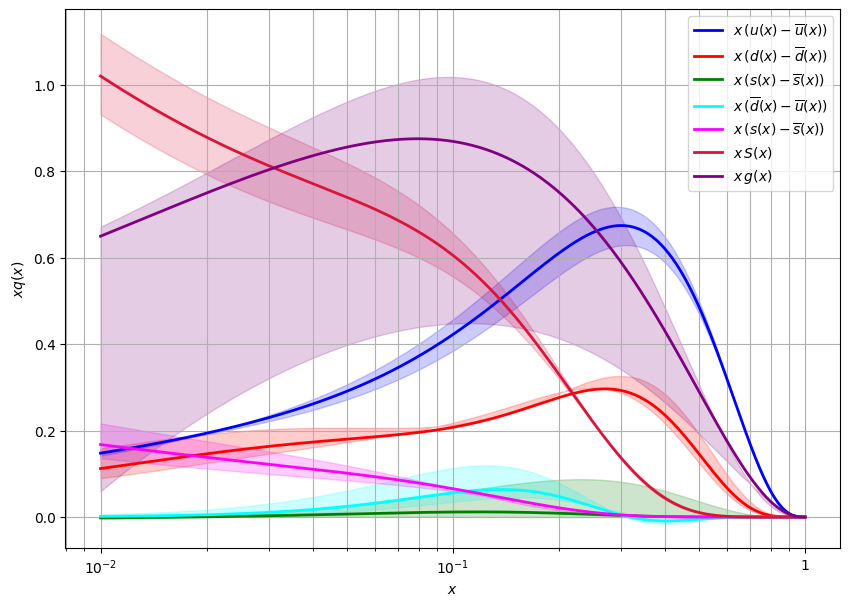

In [11]:
# Log Plot of PDFs
# Define the range for x from 10^-2 to 1
x_values = np.geomspace(1e-2, 1, 1000)

# Calculate uv(x) for the central value, plus and minus errors
x_uv_central = x_values * uv(x_values, "central")
x_uv_plus = x_values * uv(x_values, "plus")
x_uv_minus = x_values * uv(x_values, "minus")

# Define dv(x) for the central value, plus and minus errors
x_dv_central = x_values * dv(x_values, "central")
x_dv_plus = x_values * dv(x_values, "plus")
x_dv_minus = x_values * dv(x_values, "minus")

# Define sv(x) for the central value, plus and minus errors
x_sv_central = x_values * sv(x_values, "central")
x_sv_plus = x_values * sv(x_values, "plus")
x_sv_minus = x_values * sv(x_values, "minus")

# Define Delta(x) for the central value, plus and minus errors
x_Delta_central = x_values * Delta(x_values, "central")
x_Delta_plus = x_values * Delta(x_values, "plus")
x_Delta_minus = x_values * Delta(x_values, "minus")

# Define s_+(x) for the central value, plus and minus errors
x_s_p_central = x_values * s_plus(x_values, "central")
x_s_p_plus = x_values * s_plus(x_values, "plus")
x_s_p_minus = x_values * s_plus(x_values, "minus")

# Define Sv(x) for the central value, plus and minus errors
x_Sv_central = x_values * Sv(x_values, "central")
x_Sv_plus = x_values * Sv(x_values, "plus")
x_Sv_minus = x_values * Sv(x_values, "minus")

# Define gv(x) for the central value, plus and minus errors
x_gv_central = x_values * gv(x_values, "central")
x_gv_plus = x_values * gv(x_values, "plus")
x_gv_minus = x_values * gv(x_values, "minus")


# Create the plot
plt.figure(figsize=(10, 7))

# Set logarithmic scale for the x-axis
plt.xscale('log')

# Customize ticks and labels
# Custom formatter function
def custom_log_formatter(val, pos):
    if val == 1:  # 10^0
        return "1"
    else:
        return f"$10^{{{int(np.log10(val))}}}$"
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0))  # Major ticks at 10^n
plt.gca().xaxis.set_major_formatter(FuncFormatter(custom_log_formatter))

# Plot uv(x)
plt.plot(x_values, x_uv_central, label="$x\,(u(x)-\overline{u}(x))$", color="blue", linewidth=2)
plt.fill_between(x_values, x_uv_minus, x_uv_plus, color="blue", alpha=0.2)

# Plot dv(x)
plt.plot(x_values, x_dv_central, label="$x\,(d(x)-\overline{d}(x))$", color="red", linewidth=2)
plt.fill_between(x_values, x_dv_minus, x_dv_plus, color="red", alpha=0.2)

# Plot sv(x)
plt.plot(x_values, x_sv_central, label="$x\,(s(x)-\overline{s}(x))$", color="green", linewidth=2)
plt.fill_between(x_values, x_sv_minus, x_sv_plus, color="green", alpha=0.2)

# Plot Delta(x)
plt.plot(x_values, x_Delta_central, label="$x\,(\overline{d}(x)-\overline{u}(x))$", color="cyan", linewidth=2)
plt.fill_between(x_values, x_Delta_minus, x_Delta_plus, color="cyan", alpha=0.2)

# Plot s_+(x)
plt.plot(x_values, x_s_p_central, label="$x\,(s(x)-\overline{s}(x))$", color="magenta", linewidth=2)
plt.fill_between(x_values, x_s_p_minus, x_s_p_plus, color="magenta", alpha=0.2)

# Plot Sv(x)
plt.plot(x_values, x_Sv_central, label="$x\,S(x)$", color="crimson", linewidth=2)
plt.fill_between(x_values, x_Sv_minus, x_Sv_plus, color="crimson", alpha=0.2)

# Plot gv(x)
plt.plot(x_values, x_gv_central, label="$x\,g(x)$", color="purple", linewidth=2)
plt.fill_between(x_values, x_gv_minus, x_gv_plus, color="purple", alpha=0.2)

# Set plot labels, legend, and grid
plt.xlabel("$x$")
plt.ylabel("$xq(x)$")
plt.legend()
plt.grid(True,which="both")

# Display the plot
plt.show()


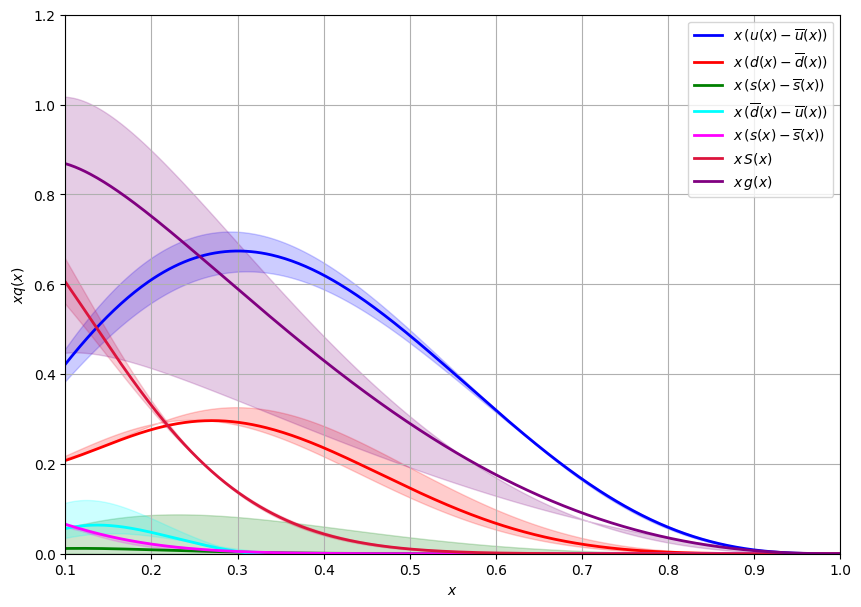

In [12]:
# Linear Plot of PDFs
# Define the range for x from 10^-2 to 1
x_values = np.linspace(1e-2, 1, 500)

# Calculate uv(x) for the central value, plus and minus errors
x_uv_central = x_values * uv(x_values, "central")
x_uv_plus = x_values * uv(x_values, "plus")
x_uv_minus = x_values * uv(x_values, "minus")

# Define dv(x) for the central value, plus and minus errors
x_dv_central = x_values * dv(x_values, "central")
x_dv_plus = x_values * dv(x_values, "plus")
x_dv_minus = x_values * dv(x_values, "minus")

# Define sv(x) for the central value, plus and minus errors
x_sv_central = x_values * sv(x_values, "central")
x_sv_plus = x_values * sv(x_values, "plus")
x_sv_minus = x_values * sv(x_values, "minus")

# Define s_+(x) for the central value, plus and minus errors
x_s_p_central = x_values * s_plus(x_values, "central")
x_s_p_plus = x_values * s_plus(x_values, "plus")
x_s_p_minus = x_values * s_plus(x_values, "minus")

# Define Sv(x) for the central value, plus and minus errors
x_Sv_central = x_values * Sv(x_values, "central")
x_Sv_plus = x_values * Sv(x_values, "plus")
x_Sv_minus = x_values * Sv(x_values, "minus")


# Define Delta(x) for the central value, plus and minus errors
x_Delta_central = x_values * Delta(x_values, "central")
x_Delta_plus = x_values * Delta(x_values, "plus")
x_Delta_minus = x_values * Delta(x_values, "minus")

# Define gv(x) for the central value, plus and minus errors
x_gv_central = x_values * gv(x_values, "central")
x_gv_plus = x_values * gv(x_values, "plus")
x_gv_minus = x_values * gv(x_values, "minus")


# Create the plot
plt.figure(figsize=(10, 7))
# Specify plot range
plt.xlim(.1,1)
plt.ylim(0,1.2)

# Plot uv(x)
plt.plot(x_values, x_uv_central, label="$x\,(u(x)-\overline{u}(x))$", color="blue", linewidth=2)
plt.fill_between(x_values, x_uv_minus, x_uv_plus, color="blue", alpha=0.2)

# Plot dv(x)
plt.plot(x_values, x_dv_central, label="$x\,(d(x)-\overline{d}(x))$", color="red", linewidth=2)
plt.fill_between(x_values, x_dv_minus, x_dv_plus, color="red", alpha=0.2)

# Plot sv(x)
plt.plot(x_values, x_sv_central, label="$x\,(s(x)-\overline{s}(x))$", color="green", linewidth=2)
plt.fill_between(x_values, x_sv_minus, x_sv_plus, color="green", alpha=0.2)

# Plot Delta(x)
plt.plot(x_values, x_Delta_central, label="$x\,(\overline{d}(x)-\overline{u}(x))$", color="cyan", linewidth=2)
plt.fill_between(x_values, x_Delta_minus, x_Delta_plus, color="cyan", alpha=0.2)

# Plot s_+(x)
plt.plot(x_values, x_s_p_central, label="$x\,(s(x)-\overline{s}(x))$", color="magenta", linewidth=2)
plt.fill_between(x_values, x_s_p_minus, x_s_p_plus, color="magenta", alpha=0.2)

# Plot Sv(x)
plt.plot(x_values, x_Sv_central, label="$x\,S(x)$", color="crimson", linewidth=2)
plt.fill_between(x_values, x_Sv_minus, x_Sv_plus, color="crimson", alpha=0.2)

# Plot gv(x)
plt.plot(x_values, x_gv_central, label="$x\,g(x)$", color="purple", linewidth=2)
plt.fill_between(x_values, x_gv_minus, x_gv_plus, color="purple", alpha=0.2)

# Set plot labels, legend, and grid
plt.xlabel("$x$")
plt.ylabel("$xq(x)$")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


RGE evolution of $\alpha_s(Q^2)$

In [13]:
def RGE_alpha_S(mu2):
    """
    Evolve alpha_S=g**/(4pi) from some input scale mu2_in to some other scale mu2.
    Note that the MSTW best fit obtains alpha_S(mu2=1 GeV**2)=0.68183, different from the world average
    
    Arguments:
    mu -- The momentum scale of the process
    
    Returns:
    The evolved value of alpha_s at mu**2
    """
    # Set parameters
    Nc = 3
    Nf = 3
    mu_R2 = 1 # 1 GeV**2
    # Extract value of alpha_S at the renormalization point of mu_R**2 = 1 GeV**2
    index_alpha_S=MSTWpdf[MSTWpdf["Parameter"] == "alpha_S(Q0^2)"].index[0]
    alpha_S_in = MSTWpdf_LO.iloc[index_alpha_S,0][0]
    beta_0 = 11/3 * Nc - 2/3* Nf

     # Evolve using LO RGE
    log_term = np.log(mu2 / mu_R2)
    denominator = 1 + (alpha_S_in / (4 * np.pi)) * beta_0 * log_term
    
    # Debug:
    # print(index_alpha_S)
    # print(alpha_S_in)

    result = alpha_S_in / denominator

    return result

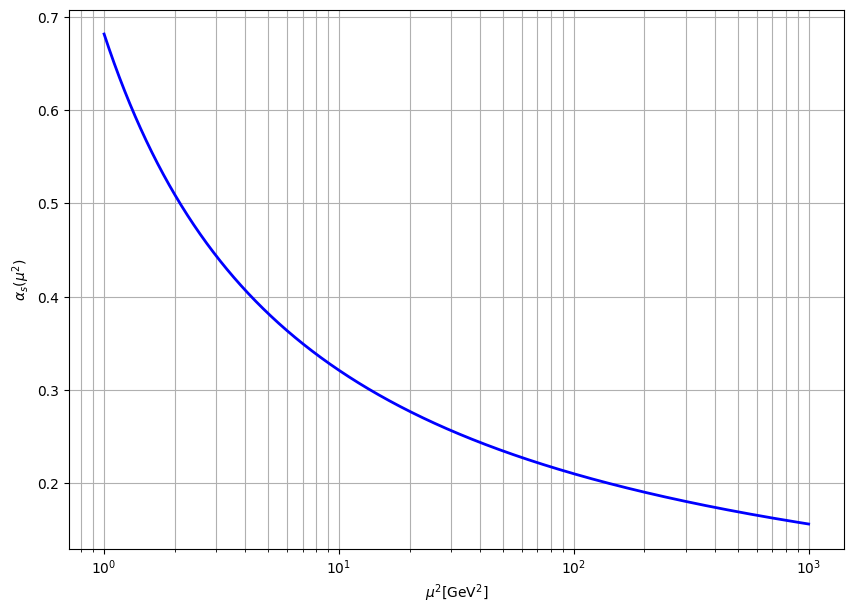

In [14]:
# Log Plot of RGE
# Define the range for x from .5 GeV**2 to 10 GeV**2
mu2_values = np.geomspace(1, 10**3, 10**4)
# mu2_values = np.linspace(1, 10**2, 10**3)

# Evolve alpha_s from mu2=1 GeV**2 on a mu2 grid
x_alpha_S= RGE_alpha_S(mu2_values)

# Create the plot
plt.figure(figsize=(10, 7))

# Set logarithmic scale for the x-axis
plt.xscale('log')

# Plot uv(x)
plt.plot(mu2_values, x_alpha_S, color="blue", linewidth=2)

# Set plot labels, legend, and grid
plt.xlabel("$\\mu^2[\mathrm{GeV}^2]$")
plt.ylabel("$\\alpha_s(\\mu^2)$")
plt.grid(True,which="both")

# Display the plot
plt.show()

Conformal moments $G_q(n,\eta,t)$ and their RGE evolution

In [ ]:
# Define Reggeized conformal moments
def uv_minus_dv_Regge(x,j,t, error_type="central"):
   # Value from the paper
   # alpha_prime = 1.069
   # Value optmized for range -t < 5 GeV
   alpha_prime = 0.650439
   # Normalize to 1 at t = 0
   return 1.006*(uv(x,error_type)-dv(x,error_type))*x**(j-1-alpha_prime*t)

def u_minus_d_Regge(x,j,t, error_type="central"):
   # Value optmized for range -t < 5 GeV
   alpha_prime = 0.675606
   # Normalize to 1 at t = 0
   return 1.107*(uv(x,error_type)-dv(x,error_type)-Delta(x,error_type))*x**(j-1-alpha_prime*t)

def uv_plus_dv_Regge(x,j,t, error_type="central"):
   # Value from the paper
   # alpha_prime = 1.069
   # Value optmized for range -t < 5 GeV
   alpha_prime = 0.650439
   # Normalize to 1 at t = 0
   return 1.006*(uv(x,error_type)+dv(x,error_type))*x**(j-1-alpha_prime*t)

def u_plus_d_Regge(x,j,t, error_type="central"):
   # Value from the paper
   # alpha_prime = 1.069
   # Value optmized for range -t < 5 GeV
   alpha_prime = 0.650439
   # Normalize to 1 at t = 0
   return 1.006*(uv(x,error_type)+dv(x,error_type)+Delta(x,error_type))*x**(j-1-alpha_prime*t)

def non_singlet_isovector(j, eta, t, error_type="central"):
    """
    Input non-singlet isovector quark GPD F_{u-d}^{(-)}(j) in terms of Reggeized PDFs.
    Supports scalar or array inputs for j, eta, and t.

    Arguments:
    j -- conformal spin (scalar or array)
    eta -- skewness (scalar or array)
    t -- Mandelstam t (scalar or array)
    error_type -- Type of error handling (default: "central")

    Returns:
    results -- Array of results corresponding to the input shapes.
    """
    
    # Vectorize the evaluation function to handle arrays and scalars
    def evaluate_single(j_val, eta_val, t_val):
        # Neglect Delta = dbar - ubar contribution
        result, error = quad(uv_minus_dv_Regge, 1e-6, 1, args=(j_val, t_val, error_type))
        # Include Delta = dbar - ubar
        #result, error = quad(u_minus_d_Regge, 1e-6, 1, args=(j_val, t_val, error_type))
        if error > 10e-2:
            print(f"Warning: Error above tolerance for j={j_val}, eta={eta_val}, t={t_val}, error_type={error_type}: {error}")

        if error > 1:
            raise ValueError(f"Computation aborted: Error > 1 for j={j_val}, eta={eta_val}, t={t_val}, error_type={error_type}: {error}")
        return result

    # Ensure inputs are numpy arrays
    j = np.atleast_1d(j)
    eta = np.atleast_1d(eta)
    t = np.atleast_1d(t)

    # Create meshgrid for all combinations of inputs
    j_grid, eta_grid, t_grid = np.meshgrid(j, eta, t, indexing='ij')
    
    # Vectorize the function over the meshgrid
    vectorized_evaluation = np.vectorize(evaluate_single)
    results = vectorized_evaluation(j_grid, eta_grid, t_grid)
    
    return results

# RGEs of moments
def gamma_qq(j):
   """"
   Return conformal spin-j anomalous dimension

   Arguments:
   j -- conformal spin
   """
   if j < 0:
    raise ValueError("j must be positive.")

   Nc = 3
   Cf = (Nc**2-1)/(2*Nc)
   result = - Cf * (-4*digamma(j+2)+4*digamma(1)+2/((j+1)*(j+2))+3)

   return result

def RGE_non_singlet_isovector(j,eta,t,mu2,error_type="central"):
   """
   Evolve the conformal moment F_{u-d}^{(-)}(j) from some input scale mu2_in to some other scale mu2.
   Note that the MSTW best fit obtains alpha_S(mu2=1 GeV**2)=0.68183, different from the world average

   Arguments:
   j -- conformal spin
   mu -- The momentum scale of the process

   Returns:
   The evolved value of F_{u-d}^{(-)}(j) at mu2
   """
   # Set parameters
   Nc = 3
   Nf = 3
   beta_0 = 11/3 * Nc - 2/3* Nf

   # Extract value of alpha_S at the renormalization point of mu_R**2 = 1 GeV**2
   index_alpha_S=MSTWpdf[MSTWpdf["Parameter"] == "alpha_S(Q0^2)"].index[0]
   alpha_S_in = MSTWpdf_LO.iloc[index_alpha_S,0][0]

   GPD_in = non_singlet_isovector(j,eta,t,error_type)
   anomalous_dim = gamma_qq(j-1)
   result = GPD_in * (alpha_S_in/RGE_alpha_S(mu2))**(anomalous_dim/beta_0)
   
   # Debug
   #print(GPD_in)
   #print((alpha_S_in/RGE_alpha_S(mu2)))
   #print(anomalous_dim/beta_0)

   return result


Plots

/tmp/ipykernel_22841/859468035.py:50: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, error = quad(uv_minus_dv_Regge, 1e-6, 1, args=(j_val, t_val, error_type))


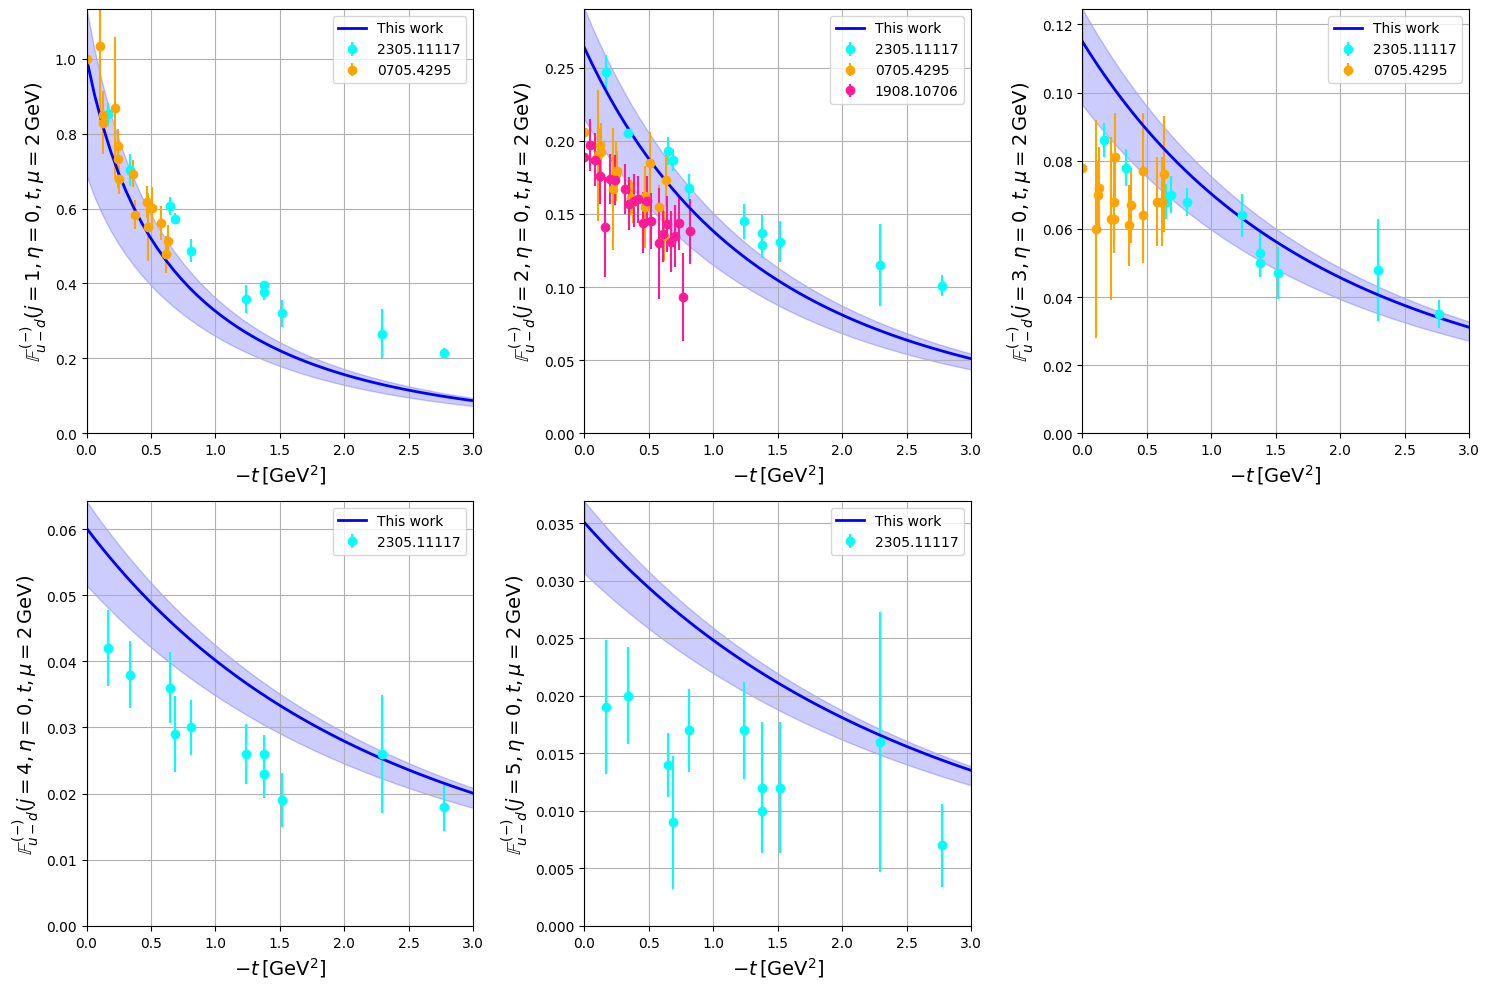

In [35]:
# Set moment_type and moment_label
moment_type = "NonSingletIsovector"
moment_label = "A"
t_max= 3

# Initialize a list to store the number of n values per publication
publication_data = {}

# Loop through each publication ID to calculate the total number of plots
for pub_id in publication_mapping:
    data,_ = load_lattice_data(moment_type, moment_label, pub_id)
    num_n_values = (data.shape[1] - 1) // 2  # Number of `n` values
    publication_data[pub_id] = num_n_values

# Find the highest n value across all publications
max_n_value = max(publication_data.values())

# Set the number of columns for the grid layout
num_columns = 3

# Calculate the number of rows needed (ceil of max_n_value / num_columns)
num_rows = (max_n_value + num_columns - 1) // num_columns

# Initialize the figure and axes for subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, num_rows * 5))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Define the finer grid for t-values from -t_max GeV^2 to 0 GeV^2 (with 50 points)
t_fine = np.linspace(-t_max, 0, 50)

# Loop through each n value up to the maximum n value
for n in range(1, max_n_value + 1):
    # Select the appropriate axis for the current plot
    ax = axes[n - 1]  # n-1 because axes is zero-indexed
    
    # Loop through each publication ID, retrieve the filename and color, and plot the data
    for pub_id, color in publication_mapping.items():
        # Get the t_values, Fn0_values, and Fn0_errors for each publication and `n`
        t_vals = t_values(moment_type, moment_label, pub_id)
        Fn0_vals = Fn0_values(n, moment_type, moment_label, pub_id)
        Fn0_errs = Fn0_errors(n, moment_type, moment_label, pub_id)
        
        # Check if data exists for the current n (i.e., Fn0_vals and Fn0_errs are not empty)
        if Fn0_vals is None or Fn0_errs is None:
            continue  # Skip if no data available for this n
        
        # Plot the data with error bars, using the corresponding color and label
        label = f"{pub_id}"
        ax.errorbar(t_vals, Fn0_vals, yerr=Fn0_errs, fmt='o', color=color, label=label)
    
    # Plot the RGE functions for each `n` over the finer grid
    x_RGE_non_singlet_isovector = RGE_non_singlet_isovector(n, 0, t_fine, 2**2, error_type="central")[0, 0, :]
    x_plus_RGE_non_singlet_isovector = RGE_non_singlet_isovector(n, 0, t_fine, 2**2, error_type="plus")[0, 0, :]
    x_minus_RGE_non_singlet_isovector = RGE_non_singlet_isovector(n, 0, t_fine, 2**2, error_type="minus")[0, 0, :]

    # Plot the central value of the RGE function over the finer grid
    ax.plot(-t_fine, x_RGE_non_singlet_isovector, color="blue", linewidth=2, label=f"This work")

    # Fill the area between the plus and minus RGE error bands over the finer grid
    ax.fill_between(-t_fine, x_minus_RGE_non_singlet_isovector, x_plus_RGE_non_singlet_isovector, color="blue", alpha=0.2)

    # Add plot labels and legend for each `n` plot
    ax.set_xlabel("$-t\,[\mathrm{GeV}^2]$", fontsize=14)
    ax.set_ylabel(f"$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}(j={n}, \\eta=0, t, \\mu=2\, \\mathrm{{GeV}})$", fontsize=14)
    ax.legend()
    ax.grid(True,which="both")

    # Set the y-axis limits to be symmetric around 0
    y_max = np.max(x_plus_RGE_non_singlet_isovector)  # Max of the function
    ax.set_ylim([0, y_max])  # Set the lower limit to 0 and upper limit to the max value
    ax.set_xlim([0,t_max])

# Remove any unused axes (if there are fewer than max_n_value plots)
for i in range(max_n_value, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

# Clean up the variables
del moment_type, moment_label